In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

In [2]:
# Load the image
image_path = "../data/images/ngc2403.png"
image_data = np.dot(plt.imread(image_path)[..., :3], [0.2989, 0.5870, 0.1140])

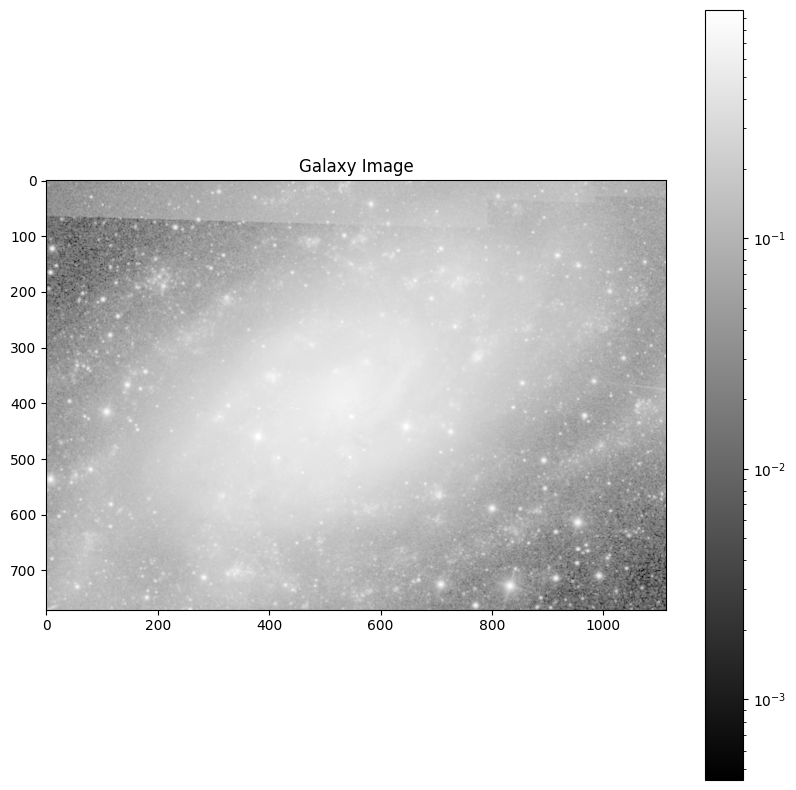

In [3]:
# Display the image using a logarithmic scale for better visualization
plt.figure(figsize=(10, 10))
plt.imshow(image_data, norm=LogNorm(), cmap='gray')
plt.colorbar()
plt.title('Galaxy Image')
plt.show()


Refined center coordinates: x=543.0373150936898, y=421.9223392422711


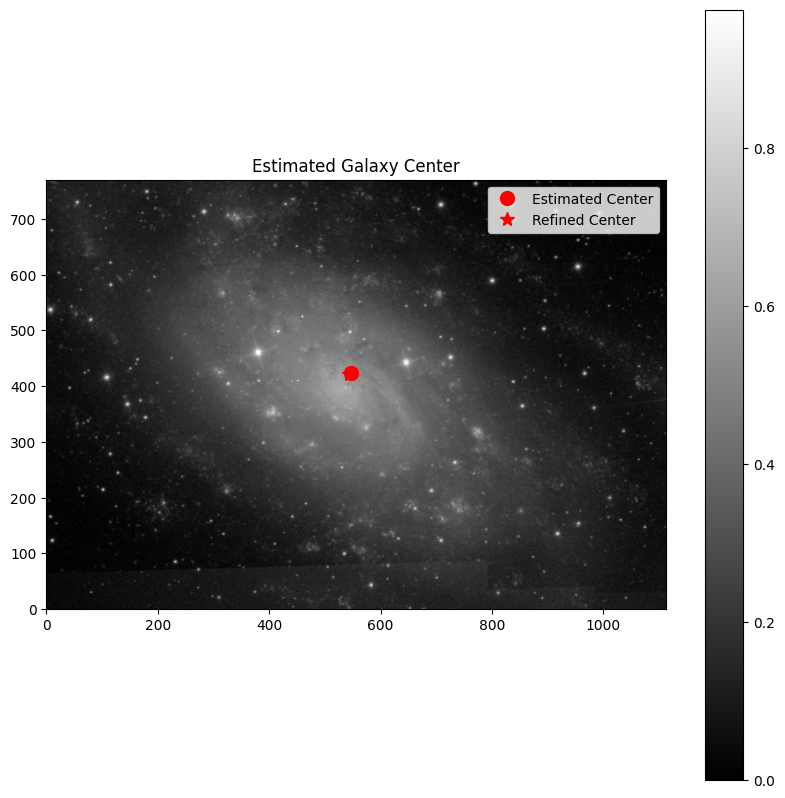

Estimated center coordinates: x=546, y=424


In [7]:
# Sum intensities along x and y axes
sum_x = np.sum(image_data, axis=0)
sum_y = np.sum(image_data, axis=1)

# Find the peak in the marginal sums
center_x = np.argmax(sum_x)
center_y = np.argmax(sum_y)

from photutils.centroids import centroid_com

# Define a small box around the approximate center to refine the centroid calculation
box_size = 50  # Adjust based on the image scale
x_min, x_max = max(0, center_x - box_size), min(image_data.shape[1], center_x + box_size)
y_min, y_max = max(0, center_y - box_size), min(image_data.shape[0], center_y + box_size)

sub_image = image_data[y_min:y_max, x_min:x_max]

# Calculate the centroid
centroid_y, centroid_x = centroid_com(sub_image)

# Adjust centroid relative to the full image
refined_center_x = x_min + centroid_x
refined_center_y = y_min + centroid_y


# Display the center location
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap='gray', origin='lower')
plt.plot(center_x, center_y, 'ro', markersize=10, label='Estimated Center')
plt.plot(refined_center_x, refined_center_y, 'r*', markersize=10, label='Refined Center')
print(f"Refined center coordinates: x={refined_center_x}, y={refined_center_y}")
plt.legend()
plt.colorbar()
plt.title('Estimated Galaxy Center')
plt.show()

print(f"Estimated center coordinates: x={center_x}, y={center_y}")


In [9]:
#image_data shape
print(image_data.shape)

(771, 1113)


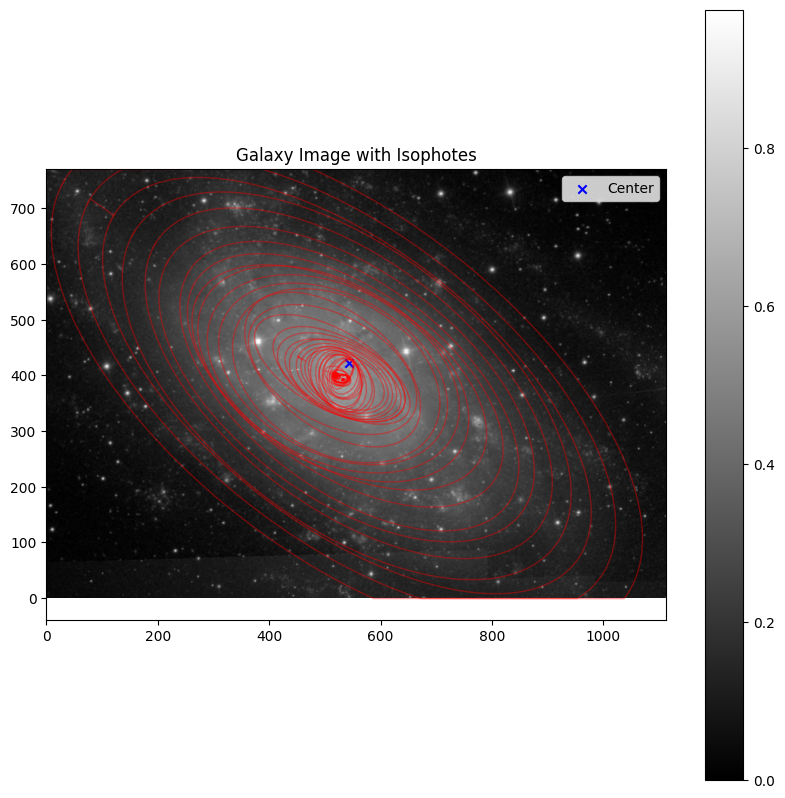

In [52]:
import numpy as np
from photutils.isophote import Ellipse, EllipseGeometry, build_ellipse_model

# Define the geometry starting at the refined center
geometry = EllipseGeometry(
    x0=refined_center_x, y0=refined_center_y, sma=200, eps=0.2, pa=np.deg2rad(135)
)  # sma is the semi-major axis

# Build an ellipse using the image data
ellipse = Ellipse(image_data, geometry)

# Fit the isophotes to the image data
isolist = ellipse.fit_image()

# Plot the image with fitted isophotes
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Galaxy Image with Isophotes')

# Overlay isophotes
for iso in isolist:
    x, y = iso.sampled_coordinates()
    plt.plot(x, y, color='red', lw=1.0, alpha=0.4)

plt.scatter(refined_center_x, refined_center_y, color='blue', marker='x', label='Center')
plt.legend()
plt.show()


In [54]:
# from photutils.isophote import build_ellipse_model
# # Create the isophote model
# iso_model = build_ellipse_model(image_data.shape, isolist)

# # Subtract the isophote model from the image
# residual_image = image_data - iso_model

# # Plot the residual image
# plt.figure(figsize=(10, 10))
# plt.imshow(residual_image, cmap='gray', origin='lower', vmin=-10, vmax=10)
# plt.colorbar()
# plt.title('Residual Image after Isophote Subtraction')
# plt.show()


/tmp/ipykernel_9226/323105699.py:16: RuntimeWarning: invalid value encountered in log10
  surface_brightness = -2.5 * np.log10(np.array(mean_intensity) - median)


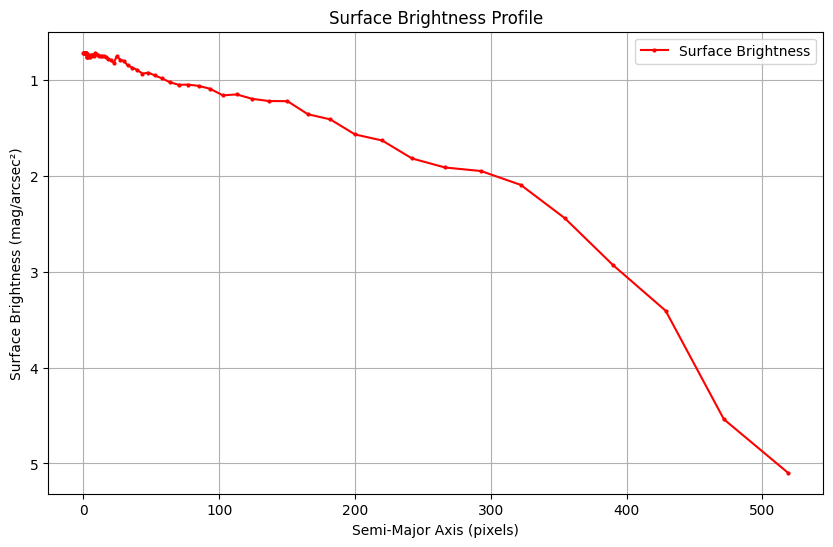

In [55]:
from astropy.stats import sigma_clipped_stats

# Calculate the background statistics
mean, median, stddev = sigma_clipped_stats(image_data)

# Extract radius (sma) and mean intensity from each isophote
radii = []
mean_intensity = []

for iso in isolist:
    radii.append(iso.sma)  # Semi-major axis of the isophote
    mean_intensity.append(iso.intens)

# Convert mean intensity to surface brightness in magnitude scale
# Using a simple conversion: mag = -2.5 * log10(intensity)
surface_brightness = -2.5 * np.log10(np.array(mean_intensity) - median)

# Plot the surface brightness profile
plt.figure(figsize=(10, 6))
plt.plot(radii, surface_brightness, '-o', color='red', label='Surface Brightness', markersize=2)
plt.gca().invert_yaxis()  # Magnitude decreases as brightness increases
plt.xlabel('Semi-Major Axis (pixels)')
plt.ylabel('Surface Brightness (mag/arcsec²)')
plt.title('Surface Brightness Profile')
plt.grid(True)
plt.legend()
plt.show()


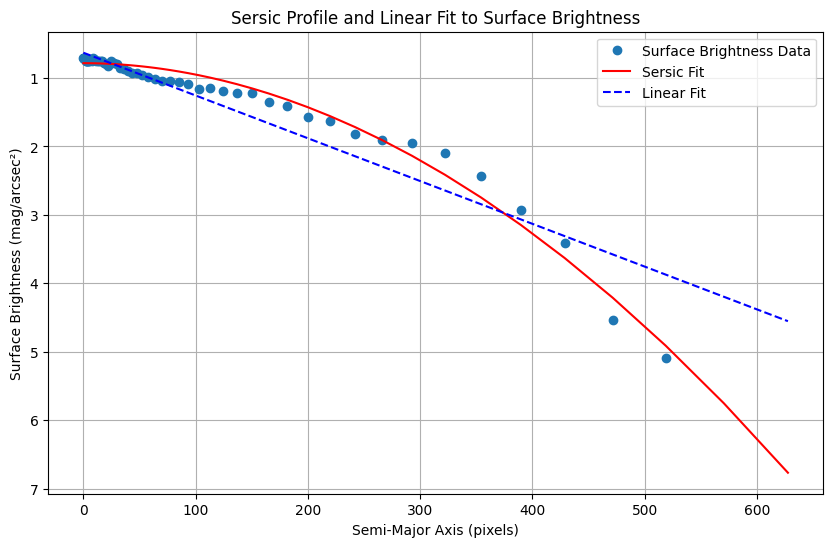

Fitted Sersic Parameters: mu_e=2.53 mag/arcsec², r_e=333.90 pixels, n=0.51
Fitted Linear Parameters: a=0.01, b=0.63


In [56]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Sersic profile in surface brightness
def sersic_surface_brightness(r, mu_e, r_e, n):
    b_n = 2 * n - 0.327
    return mu_e + 2.5 * b_n * ((r / r_e)**(1/n) - 1)

# Define a linear function
def linear_surface_brightness(r, a, b):
    return a * r + b

non_nan_radii = np.array(radii)[~np.isnan(surface_brightness)]
non_nan_surface_brightness = surface_brightness[~np.isnan(surface_brightness)]

# Fit the Sersic profile to the surface brightness data
popt_sersic, pcov_sersic = curve_fit(sersic_surface_brightness, non_nan_radii, non_nan_surface_brightness, p0=[20, 10, 2])
mu_e, r_e, n = popt_sersic

# Fit the linear function to the surface brightness data
popt_linear, pcov_linear = curve_fit(linear_surface_brightness, non_nan_radii, non_nan_surface_brightness)
a, b = popt_linear

# Plot the data, the fitted Sersic profile, and the linear fit
plt.figure(figsize=(10, 6))
plt.plot(radii, surface_brightness, 'o', label='Surface Brightness Data')
plt.plot(radii, sersic_surface_brightness(np.array(radii), *popt_sersic), '-', color='red', label='Sersic Fit')
plt.plot(radii, linear_surface_brightness(np.array(radii), *popt_linear), '--', color='blue', label='Linear Fit')
plt.gca().invert_yaxis()  # Magnitude scale, lower values mean brighter
plt.xlabel('Semi-Major Axis (pixels)')
plt.ylabel('Surface Brightness (mag/arcsec²)')
plt.title('Sersic Profile and Linear Fit to Surface Brightness')
plt.grid(True)
plt.legend()
plt.show()

print(f"Fitted Sersic Parameters: mu_e={mu_e:.2f} mag/arcsec², r_e={r_e:.2f} pixels, n={n:.2f}")
print(f"Fitted Linear Parameters: a={a:.2f}, b={b:.2f}")